In [ ]:
#import libraries
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np

Loading Dataset

In [ ]:
from google.colab import files
uploaded = files.upload()

Saving dataset.zip to dataset.zip


In [ ]:
import os
import zipfile

raw_file ='/content/dataset.zip'
extract_path ='/content/' #image extract path

#Extract all images
with zipfile.ZipFile(raw_file, 'r') as zipRef:
  zipRef.extractall(extract_path)

Generate Dataset

In [ ]:
#Transformer
import torchvision.transforms as transform

transformer = transform.Compose([
    transform.Resize((128,128)),
    transform.ToTensor(),
    transform.Normalize(mean=[0.5]*3, std=[0.5]*3)
])

In [ ]:
import torchvision.datasets as datasets

data_path = '/content/Bone Break Classification/Bone Break Classification'
dataset = datasets.ImageFolder(data_path, transform=transformer)
dataset.classes

['Avulsion fracture',
 'Comminuted fracture',
 'Fracture Dislocation',
 'Greenstick fracture',
 'Hairline Fracture',
 'Impacted fracture',
 'Longitudinal fracture',
 'Oblique fracture',
 'Pathological fracture',
 'Spiral Fracture']

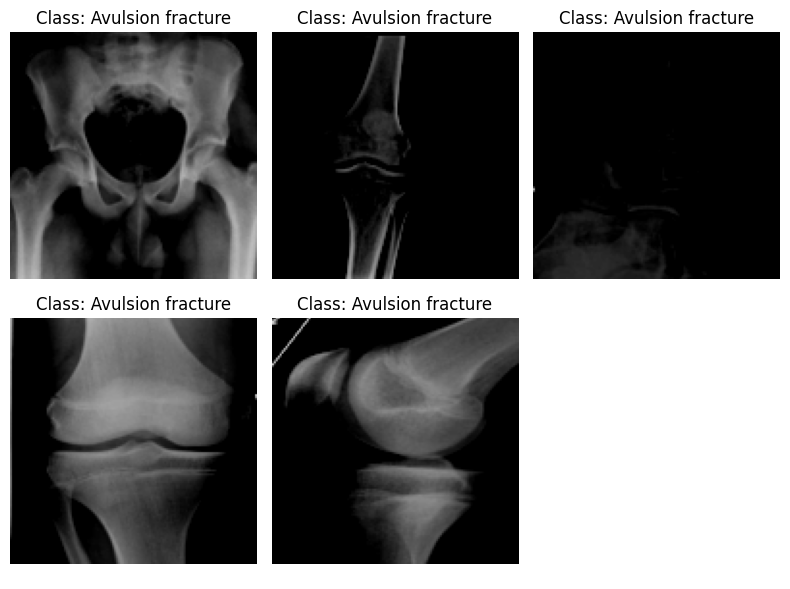

In [ ]:
import math
#sample images and classes from recreated data folder
sample_size = 5
cols = 3
rows = math.ceil(sample_size/cols)
fig, axes = plt.subplots(rows, cols, figsize=(8,6))
axes = axes.flatten()

for i in range(sample_size):
    img, label = dataset[i]
    ax = axes[i]
    #
    ax.imshow(img.permute(1,2,0))
    ax.set_title(f'Class: {dataset.classes[label]}')
    ax.axis('off')

    # Turn off unused subplots if any
for j in range(sample_size, len(axes)):
    axes[j].axis('off')

plt.tight_layout()
plt.show()

###Train, Validaion and Test Splits

In [ ]:
import torch.utils.data as data

train_size = int(0.7*len(dataset))
val_size = int(0.15*len(dataset))
test_size = len(dataset) - train_size - val_size

train_data, val_data, test_data = data.random_split(dataset,[train_size,val_size,test_size])

Data Loader

In [ ]:
batch_size = 32 #can use 16,32,64,128 based on hardware capacities

#shuffule is true for train to ensure model does not learn order of data to make predictions
train_loader = data.DataLoader(train_data, batch_size = batch_size, shuffle = True)

val_loader = data.DataLoader(val_data, batch_size = batch_size, shuffle = False)
test_loader = data.DataLoader(test_data, batch_size = batch_size, shuffle = False)

In [ ]:
img, labels = train_data[0]
print(f'Image: {img}....Label: {labels}')

Image: tensor([[[-1., -1., -1.,  ..., -1., -1., -1.],
         [-1., -1., -1.,  ..., -1., -1., -1.],
         [-1., -1., -1.,  ..., -1., -1., -1.],
         ...,
         [-1., -1., -1.,  ..., -1., -1., -1.],
         [-1., -1., -1.,  ..., -1., -1., -1.],
         [-1., -1., -1.,  ..., -1., -1., -1.]],

        [[-1., -1., -1.,  ..., -1., -1., -1.],
         [-1., -1., -1.,  ..., -1., -1., -1.],
         [-1., -1., -1.,  ..., -1., -1., -1.],
         ...,
         [-1., -1., -1.,  ..., -1., -1., -1.],
         [-1., -1., -1.,  ..., -1., -1., -1.],
         [-1., -1., -1.,  ..., -1., -1., -1.]],

        [[-1., -1., -1.,  ..., -1., -1., -1.],
         [-1., -1., -1.,  ..., -1., -1., -1.],
         [-1., -1., -1.,  ..., -1., -1., -1.],
         ...,
         [-1., -1., -1.,  ..., -1., -1., -1.],
         [-1., -1., -1.,  ..., -1., -1., -1.],
         [-1., -1., -1.,  ..., -1., -1., -1.]]])....Label: 8


### CNN using PyTorch ####

In [ ]:
import torch
from torch import optim
from torch import nn
from torch.utils.data import DataLoader

import torchvision
import torch.nn.functional as F
import torchvision.datasets as datasets
import torchvision.transforms as transforms

In [ ]:
#CNN Model
class CNN_Model(nn.Module):
  def __init__(self,num_classes):
    super(CNN_Model, self).__init__()

    #Conv Layers
    self.conv1 = nn.Conv2d(in_channels=3, out_channels=32, kernel_size=3, padding=1)
    self.pool = nn.MaxPool2d(kernel_size=2, stride=2)
    self.conv2 = nn.Conv2d(in_channels=32, out_channels=64, kernel_size=3, padding=1)
    self.conv3 = nn.Conv2d(in_channels=64, out_channels=128, kernel_size=3, padding=1)

    # Fully Connected Layers
    self.fc1 = nn.Linear(128*16*16, 100)
    self.fc2 = nn.Linear(100, num_classes)

  def forward(self, x):
          x = self.pool(F.relu(self.conv1(x)))
          x = self.pool(F.relu(self.conv2(x)))
          x = self.pool(F.relu(self.conv3(x)))

          x = x.view(x.size(0), -1)
          x = F.relu(self.fc1(x))
          x = self.fc2(x)
          return x


### Train and Evaluate Functions

In [ ]:
import copy
#function to train model
def train_model(model, train_loader, val_loader, criterion, device, epochs = 10, patience = 3):
  best_model_weights = copy.deepcopy(model.state_dict())
  best_val_loss = float('inf')
  trigger_times = 0

  for epoch in range(epochs):
    model.train() #set model to train mode
    running_loss = 0.0

    for images, labels in train_loader:
      images, labels = images.to(device), labels.to(device)

      optimizer.zero_grad() #reset the gradient
      outputs = model(images) #forward pass
      loss = criterion(outputs, labels) #compute loss
      loss.backward() #pass backward
      optimizer.step() #update weights

      running_loss += loss.item()

    train_loss = running_loss/len(train_loader)

    #--------- Validation ------------#
    model.eval()
    val_loss = 0.0
    correct = 0
    total = 0

    with torch.no_grad():
      for images, labels in val_loader:
        images, labels = images.to(device), labels.to(device)
        outputs = model(images)
        loss = criterion(outputs, labels)
        val_loss += loss.item()

        _, preds = torch.max(outputs, 1)
        correct += (preds==labels).sum().item()
        total += labels.size(0)

    val_loss /= len(val_loader.dataset)
    val_acc = correct/total

    print(f'Epoch [{epoch+1}/{epochs}] - Train Loss: {train_loss:.4f} | Val Loss: {val_loss:.4f} | Val Acc: {val_acc:.4f} ')


    #------ Checkipoint for best model ------#

    if val_loss < best_val_loss:
      best_val_loss = val_loss
      best_model_weights = copy.deepcopy(model.state_dict())
      trigger_times = 0 #reset to 0
      print('New Best model saved')
    else:
      trigger_times += 1
      if trigger_times >= patience:
        print(f'Early stopping triggered after {patience} non improvement epochs.')
        break

  #Load best model weights
  model.load_state_dict(best_model_weights)

In [ ]:
!pip install torchmetrics
import torchmetrics

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 962.5/962.5 kB 18.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 363.4/363.4 MB 3.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 13.8/13.8 MB 50.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 24.6/24.6 MB 52.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 883.7/883.7 kB 38.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 664.8/664.8 MB 1.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 211.5/211.5 MB 6.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 56.3/56.3 MB 11.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 127.9/127.9 MB 7.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 207.5/207.5 MB 6.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 21.1/21.1 MB 58.7 MB/s eta 0:00:00
  Attempting uninstall: nvidia-nvjitlink-cu12
    Found existing installation: nvidia-nvjitlink-cu12 12.5.82
    Uninstall

In [ ]:
#function to evaluate model performance
from torchmetrics.classification import Accuracy, Precision, Recall
def model_eval(model, test_loader):
  acc = Accuracy(task="multiclass", num_classes=10)
  precision = Precision(task="multiclass", num_classes=10, average='macro')
  recall = Recall(task="multiclass", num_classes=10, average='macro')

  model.eval()
  with torch.no_grad():
    for images, labels in test_loader:
        images = images.to(device)
        labels = labels.to(device)

        outputs = model(images)
        _, preds = torch.max(outputs, 1)

        acc.update(preds, labels)
        precision.update(preds, labels)
        recall.update(preds, labels)

  test_accuracy = acc.compute()
  test_precision = precision.compute()
  test_recall = recall.compute()

  print(f"Test Accuracy: {test_accuracy*100:.2f}%")
  print(f"Test Precision: {test_precision*100:.2f}%")
  print(f"Test Recall: {test_recall*100:.2f}%")

### Initialization, Training and Evaluation

In [ ]:
num_classes = len(dataset.classes)
print(num_classes)

10


In [ ]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = CNN_Model(num_classes=num_classes).to(device)

print(f'trainable parameters {sum(p.numel() for p in model.parameters() if p.requires_grad)}')
print(model.named_parameters)

trainable parameters 3371158
<bound method Module.named_parameters of CNN_Model(
  (conv1): Conv2d(3, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (pool): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (conv2): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (conv3): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (fc1): Linear(in_features=32768, out_features=100, bias=True)
  (fc2): Linear(in_features=100, out_features=10, bias=True)
)>


In [ ]:
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)

In [ ]:
train_model(model, train_loader, val_loader, criterion, device)

Epoch [1/10] - Train Loss: 2.2904 | Val Loss: 0.0813 | Val Acc: 0.1420 
New Best model saved
Epoch [2/10] - Train Loss: 2.2227 | Val Loss: 0.0788 | Val Acc: 0.1953 
New Best model saved
Epoch [3/10] - Train Loss: 2.1120 | Val Loss: 0.0784 | Val Acc: 0.2130 
New Best model saved
Epoch [4/10] - Train Loss: 1.8931 | Val Loss: 0.0812 | Val Acc: 0.2663 
Epoch [5/10] - Train Loss: 1.5249 | Val Loss: 0.0869 | Val Acc: 0.3077 
Epoch [6/10] - Train Loss: 1.0372 | Val Loss: 0.1022 | Val Acc: 0.3018 
Early stopping triggered after 3 non improvement epochs.


In [ ]:
#Model Evaluation
model_eval(model, test_loader)

Test Accuracy: 21.18%
Test Precision: 17.37%
Test Recall: 18.53%


### CNN Using TensorFlow

In [ ]:
import tensorflow as tf
from tensorflow.keras import layers, models, optimizers

In [ ]:
#load datasets for tensorflow processing
import tensorflow as tf

img_size = 128 #image size
data_path = '/content/Bone Break Classification/Bone Break Classification'

train_data = tf.keras.utils.image_dataset_from_directory(
    directory=data_path,
    validation_split=0.3,
    subset="training",
    seed= 34,
    image_size= (img_size,img_size ),
    batch_size=32
)

val_dataset = tf.keras.utils.image_dataset_from_directory(
    directory = data_path,
    validation_split=0.3,
    subset='validation',
    image_size= (img_size, img_size),
    seed = 34,
    batch_size = 32
)

#split validation into validation and training set
val_batch = int(0.5*len(val_dataset))
val_data = val_dataset.take(val_batch) #15%
test_data = val_dataset.skip(val_batch) #15%

Found 1129 files belonging to 10 classes.
Using 791 files for training.
Found 1129 files belonging to 10 classes.
Using 338 files for validation.


Image shape: (128, 128, 3)
Label index: 6


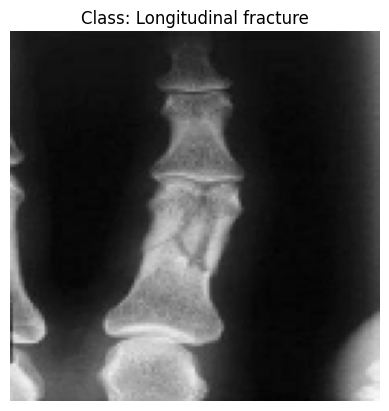

In [ ]:
# View one batch
for images, labels in train_data.take(1):
    image = images[0]         # Get the first image in the batch
    label = labels[0]         # Get the first label in the batch

    print(f"Image shape: {image.shape}")
    print(f"Label index: {label.numpy()}")

    # Display the image
    import matplotlib.pyplot as plt
    plt.imshow(image.numpy().astype("uint8"))
    plt.title(f"Class: {train_data.class_names[label]}")
    plt.axis("off")
    plt.show()
    break  # We only want one batch

In [ ]:
#simple CNN model
model = models.Sequential()

#Input Layer
model.add(layers.Input(shape=(img_size,img_size, 3)))

#Convolution Layers
model.add(layers.Conv2D(16,(3,3), activation = 'relu', padding ='same'))
model.add(layers.MaxPooling2D(2,2))
model.add(layers.Conv2D(32, (3,3), activation = 'relu', padding ='same'))
model.add(layers.MaxPooling2D(2,2))
model.add(layers.Conv2D(64, (3,3), activation = 'relu', padding ='same'))

#Dense Layers
model.add(layers.Flatten())
model.add(layers.Dense(100, activation='relu'))
model.add(layers.Dense(10, activation='softmax'))

In [ ]:
model.summary()

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d (Conv2D)                 │ (None, 128, 128, 16)   │           448 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d (MaxPooling2D)    │ (None, 64, 64, 16)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_1 (Conv2D)               │ (None, 64, 64, 32)     │         4,640 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_1 (MaxPooling2D)  │ (None, 32, 32, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_2 (Conv2D)               │ (None, 32, 32, 64)     │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ (None, 65536)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 100)            │     6,553,700 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 10)             │         1,010 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 6,578,294 (25.09 MB)

 Trainable params: 6,578,294 (25.09 MB)

 Non-trainable params: 0 (0.00 B)

In [ ]:
#compiling model with hyperparamaters: loss, optimizer, leraning rate and metrics
optimizer = optimizers.Adam(learning_rate=0.005)
model.compile(optimizer=optimizer, loss='sparse_categorical_crossentropy', metrics=['accuracy'])

In [ ]:
#training model
history = model.fit(train_data, validation_data = val_data, epochs=10)

Epoch 1/10
22/22 ━━━━━━━━━━━━━━━━━━━━ 26s 1s/step - accuracy: 0.1319 - loss: 441.3558 - val_accuracy: 0.1384 - val_loss: 2.3011
Epoch 2/10
22/22 ━━━━━━━━━━━━━━━━━━━━ 19s 880ms/step - accuracy: 0.1373 - loss: 2.2894 - val_accuracy: 0.1295 - val_loss: 2.3005
Epoch 3/10
22/22 ━━━━━━━━━━━━━━━━━━━━ 17s 712ms/step - accuracy: 0.1644 - loss: 2.2203 - val_accuracy: 0.1696 - val_loss: 2.3698
Epoch 4/10
22/22 ━━━━━━━━━━━━━━━━━━━━ 15s 667ms/step - accuracy: 0.2467 - loss: 2.0286 - val_accuracy: 0.1250 - val_loss: 2.7384
Epoch 5/10
22/22 ━━━━━━━━━━━━━━━━━━━━ 23s 697ms/step - accuracy: 0.3201 - loss: 1.8378 - val_accuracy: 0.1696 - val_loss: 3.4202
Epoch 6/10
22/22 ━━━━━━━━━━━━━━━━━━━━ 17s 605ms/step - accuracy: 0.4445 - loss: 1.5759 - val_accuracy: 0.1473 - val_loss: 3.8505
Epoch 7/10
22/22 ━━━━━━━━━━━━━━━━━━━━ 21s 611ms/step - accuracy: 0.4962 - loss: 1.4537 - val_accuracy: 0.1652 - val_loss: 3.3444
Epoch 8/10
22/22 ━━━━━━━━━━━━━━━━━━━━ 20s 578ms/step - accuracy: 0.4698 - loss: 1.5084 - val_accur

In [ ]:
#Evaluation Metrics of the Model
train_loss = history.history['loss'][-1]
train_acc = history.history['accuracy'][-1]

val_loss = history.history['val_loss'][-1]
val_acc = history.history['val_accuracy'][-1]


print(f'Train Loss: {train_loss:.2f}...Validation Loss: {val_loss:.2f}')
print(f'Train Accuracy: {train_acc*100:.2f}%... Validation Accuracy: {val_acc*100:.2f}%')

Train Loss: 1.22...Validation Loss: 6.32
Train Accuracy: 58.26%... Validation Accuracy: 12.50%


In [ ]:
#Evaluating model with test data
test_loss, test_acc = model.evaluate(test_data)
print(f"Test Accuracy: {test_acc*100:.2f}%")
print(f"Test Loss: {test_loss:.4f}")

8/8 ━━━━━━━━━━━━━━━━━━━━ 3s 285ms/step - accuracy: 0.1872 - loss: 7.3184
Test Accuracy: 17.18%
Test Loss: 7.7264


In [ ]:
##--------Improving CNN Model---------##

#Build model
model = models.Sequential()

#Input and Augmentation layer
model.add(layers.Input(shape=(img_size,img_size,3)))

#----- Convolutaional Layers -----#
#Block 1
model.add(layers.Conv2D(16, (3,3), strides=2, padding='same'))
model.add(layers.BatchNormalization())
model.add(layers.LeakyReLU(alpha=0.2))
model.add(layers.Dropout(0.2))

#Block 2
model.add(layers.Conv2D(32, (3,3), strides =2, padding='same'))
model.add(layers.BatchNormalization())
model.add(layers.LeakyReLU(alpha=0.2))
model.add(layers.Dropout(0.2))

#Block 3
model.add(layers.Conv2D(64, (3,3), strides =2, padding='same'))
model.add(layers.BatchNormalization())
model.add(layers.LeakyReLU(alpha=0.2))
model.add(layers.Dropout(0.2))

#Fully connected layers
model.add(layers.Flatten())
model.add(layers.Dense(150))
model.add(layers.BatchNormalization())
model.add(layers.LeakyReLU(alpha=0.2))
model.add(layers.Dropout(0.2))

#Output Layer
model.add(layers.Dense(10, activation='softmax'))

In [ ]:
model.summary()

Model: "sequential_3"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d_9 (Conv2D)               │ (None, 64, 64, 16)     │           448 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_8           │ (None, 64, 64, 16)     │            64 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ leaky_re_lu_8 (LeakyReLU)       │ (None, 64, 64, 16)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_16 (Dropout)            │ (None, 64, 64, 16)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_10 (Conv2D)              │ (None, 32, 32, 32)     │         4,640 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_9           │ (None, 32, 32, 32)     │           128 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ leaky_re_lu_9 (LeakyReLU)       │ (None, 32, 32, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_17 (Dropout)            │ (None, 32, 32, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_11 (Conv2D)              │ (None, 16, 16, 64)     │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_10          │ (None, 16, 16, 64)     │           256 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ leaky_re_lu_10 (LeakyReLU)      │ (None, 16, 16, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_18 (Dropout)            │ (None, 16, 16, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_3 (Flatten)             │ (None, 16384)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_23 (Dense)                │ (None, 150)            │     2,457,750 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_11          │ (None, 150)            │           600 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ leaky_re_lu_11 (LeakyReLU)      │ (None, 150)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_19 (Dropout)            │ (None, 150)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_24 (Dense)                │ (None, 10)             │         1,510 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 2,483,892 (9.48 MB)

 Trainable params: 2,483,368 (9.47 MB)

 Non-trainable params: 524 (2.05 KB)

In [ ]:
#Compile model
optimizer = optimizers.Adam(learning_rate=0.005)
model.compile(optimizer=optimizer, loss= 'sparse_categorical_crossentropy', metrics=['accuracy'])


In [ ]:
#training model
tf.config.run_functions_eagerly(True)
history = model.fit(train_data,
                    validation_data = val_data,
                    epochs=10)

Epoch 1/10
25/25 ━━━━━━━━━━━━━━━━━━━━ 13s 521ms/step - accuracy: 0.1472 - loss: 2.8475 - val_accuracy: 0.1688 - val_loss: 32.7521
Epoch 2/10
25/25 ━━━━━━━━━━━━━━━━━━━━ 13s 518ms/step - accuracy: 0.2643 - loss: 2.0969 - val_accuracy: 0.1125 - val_loss: 5.4510
Epoch 3/10
25/25 ━━━━━━━━━━━━━━━━━━━━ 13s 516ms/step - accuracy: 0.3401 - loss: 1.9501 - val_accuracy: 0.1187 - val_loss: 3.4058
Epoch 4/10
25/25 ━━━━━━━━━━━━━━━━━━━━ 20s 516ms/step - accuracy: 0.3632 - loss: 1.7850 - val_accuracy: 0.2188 - val_loss: 3.1544
Epoch 5/10
25/25 ━━━━━━━━━━━━━━━━━━━━ 20s 515ms/step - accuracy: 0.4993 - loss: 1.5141 - val_accuracy: 0.2562 - val_loss: 2.4342
Epoch 6/10
25/25 ━━━━━━━━━━━━━━━━━━━━ 21s 534ms/step - accuracy: 0.6189 - loss: 1.1372 - val_accuracy: 0.2000 - val_loss: 2.7170
Epoch 7/10
25/25 ━━━━━━━━━━━━━━━━━━━━ 21s 545ms/step - accuracy: 0.8009 - loss: 0.7349 - val_accuracy: 0.1937 - val_loss: 2.7571
Epoch 8/10
25/25 ━━━━━━━━━━━━━━━━━━━━ 14s 541ms/step - accuracy: 0.8816 - loss: 0.4831 - val_acc

In [ ]:
#Evaluation Metrics of the Model
train_loss = history.history['loss'][-1]
train_acc = history.history['accuracy'][-1]

val_loss = history.history['val_loss'][-1]
val_acc = history.history['val_accuracy'][-1]


print(f'Train Loss: {train_loss:.2f}...Validation Loss: {val_loss:.2f}')
print(f'Train Accuracy: {train_acc*100:.2f}%... Validation Accuracy: {val_acc*100:.2f}%')

Train Loss: 0.17...Validation Loss: 2.92
Train Accuracy: 96.33%... Validation Accuracy: 31.25%


In [ ]:
#Evaluating model with test data
test_loss, test_acc = model.evaluate(test_data)
print(f"Test Accuracy: {test_acc*100:.2f}%")
print(f"Test Loss: {test_loss:.2f}")

6/6 ━━━━━━━━━━━━━━━━━━━━ 1s 81ms/step - accuracy: 0.3386 - loss: 2.7645
Test Accuracy: 29.78%
Test Loss: 2.84


###Using ResNe50

In [ ]:
from tensorflow.keras.applications import ResNet50

In [ ]:
#load datasets for tensorflow processing
import tensorflow as tf

img_size = 128 #image size
data_path = '/content/Bone Break Classification/Bone Break Classification'

train_data = tf.keras.utils.image_dataset_from_directory(
    directory=data_path,
    validation_split=0.3,
    subset="training",
    seed= 34,
    image_size= (img_size,img_size ),
    batch_size=32
)

val_dataset = tf.keras.utils.image_dataset_from_directory(
    directory = data_path,
    validation_split=0.3,
    subset='validation',
    image_size= (img_size, img_size),
    seed = 34,
    batch_size = 32
)

#split validation into validation and training set
val_batch = int(0.5*len(val_dataset))
val_data = val_dataset.take(val_batch) #15%
test_data = val_dataset.skip(val_batch) #15%

Found 1129 files belonging to 10 classes.
Using 791 files for training.
Found 1129 files belonging to 10 classes.
Using 338 files for validation.


/usr/local/lib/python3.11/dist-packages/tensorflow/python/data/ops/structured_function.py:258: UserWarning: Even though the `tf.config.experimental_run_functions_eagerly` option is set, this option does not apply to tf.data functions. To force eager execution of tf.data functions, please use `tf.data.experimental.enable_debug_mode()`.
  warnings.warn(


In [ ]:
base_model = ResNet50(
    include_top = False,
    weights ='imagenet',
    input_shape = (img_size,img_size,3)
)

#freeze layers of the base model
base_model.trainable = False


x = base_model.output
x = layers.GlobalAveragePooling2D()(base_model.output)
x = layers.Dense(128, activation ='relu')(x)
x = layers.Dropout(0.2)(x)
output = layers.Dense(num_classes, activation ='softmax')(x)

resnet_model = tf.keras.Model(inputs=base_model.input, outputs= output)
resnet_model.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics=['accuracy'])

resnet_model.summary()

Model: "functional_71"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer_16      │ (None, 128, 128,  │          0 │ -                 │
│ (InputLayer)        │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1_pad           │ (None, 134, 134,  │          0 │ input_layer_16[0… │
│ (ZeroPadding2D)     │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1_conv (Conv2D) │ (None, 64, 64,    │      9,472 │ conv1_pad[0][0]   │
│                     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1_bn            │ (None, 64, 64,    │        256 │ conv1_conv[0][0]  │
│ (BatchNormalizatio… │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1_relu          │ (None, 64, 64,    │          0 │ conv1_bn[0][0]    │
│ (Activation)        │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ pool1_pad           │ (None, 66, 66,    │          0 │ conv1_relu[0][0]  │
│ (ZeroPadding2D)     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ pool1_pool          │ (None, 32, 32,    │          0 │ pool1_pad[0][0]   │
│ (MaxPooling2D)      │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_1_conv │ (None, 32, 32,    │      4,160 │ pool1_pool[0][0]  │
│ (Conv2D)            │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_1_bn   │ (None, 32, 32,    │        256 │ conv2_block1_1_c… │
│ (BatchNormalizatio… │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_1_relu │ (None, 32, 32,    │          0 │ conv2_block1_1_b… │
│ (Activation)        │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_2_conv │ (None, 32, 32,    │     36,928 │ conv2_block1_1_r… │
│ (Conv2D)            │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_2_bn   │ (None, 32, 32,    │        256 │ conv2_block1_2_c… │
│ (BatchNormalizatio… │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_2_relu │ (None, 32, 32,    │          0 │ conv2_block1_2_b… │
│ (Activation)        │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_0_conv │ (None, 32, 32,    │     16,640 │ pool1_pool[0][0]  │
│ (Conv2D)            │ 256)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_3_conv │ (None, 32, 32,    │     16,640 │ conv2_block1_2_r… │
│ (Conv2D)            │ 256)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_0_bn   │ (None, 32, 32,    │      1,024 │ conv2_block1_0_c… │
│ (BatchNormalizatio… │ 256)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_3_bn   │ (None, 32, 32,    │      1,024 │ conv2_block1_3_c

 Total params: 23,851,274 (90.99 MB)

 Trainable params: 263,562 (1.01 MB)

 Non-trainable params: 23,587,712 (89.98 MB)

In [ ]:
#Train
history = resnet_model.fit(
    train_data,
    validation_data=val_data,
    epochs=10
)

Epoch 1/10
25/25 ━━━━━━━━━━━━━━━━━━━━ 228s 9s/step - accuracy: 0.0978 - loss: 3.0715 - val_accuracy: 0.2875 - val_loss: 2.0995
Epoch 2/10
25/25 ━━━━━━━━━━━━━━━━━━━━ 247s 9s/step - accuracy: 0.3624 - loss: 1.8675 - val_accuracy: 0.3313 - val_loss: 1.9867
Epoch 3/10
25/25 ━━━━━━━━━━━━━━━━━━━━ 262s 9s/step - accuracy: 0.5200 - loss: 1.4499 - val_accuracy: 0.3438 - val_loss: 2.0326
Epoch 4/10
25/25 ━━━━━━━━━━━━━━━━━━━━ 211s 8s/step - accuracy: 0.6101 - loss: 1.2305 - val_accuracy: 0.3313 - val_loss: 2.0266
Epoch 5/10
25/25 ━━━━━━━━━━━━━━━━━━━━ 213s 9s/step - accuracy: 0.6874 - loss: 1.0182 - val_accuracy: 0.4313 - val_loss: 1.8670
Epoch 6/10
25/25 ━━━━━━━━━━━━━━━━━━━━ 215s 9s/step - accuracy: 0.7687 - loss: 0.7719 - val_accuracy: 0.4000 - val_loss: 1.9772
Epoch 7/10
25/25 ━━━━━━━━━━━━━━━━━━━━ 259s 8s/step - accuracy: 0.8470 - loss: 0.6148 - val_accuracy: 0.4000 - val_loss: 2.0617
Epoch 8/10
25/25 ━━━━━━━━━━━━━━━━━━━━ 212s 8s/step - accuracy: 0.8684 - loss: 0.4985 - val_accuracy: 0.4187 - v

In [ ]:
#Evaluating model with test data
test_loss, test_acc = resnet_model.evaluate(test_data)
print(f"Test Accuracy: {test_acc*100:.2f}%")
print(f"Test Loss: {test_loss:.2f}")

6/6 ━━━━━━━━━━━━━━━━━━━━ 13s 2s/step - accuracy: 0.4382 - loss: 1.9024
Test Accuracy: 41.57%
Test Loss: 1.96


In [ ]:
resnet_model.save('fracture_classifier_final.keras')